In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Concatenate, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# 20 Features

(1975, 20)
(1975, 2)
Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.5236 - loss: 0.9426 - val_accuracy: 0.5759 - val_loss: 0.6756
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5579 - loss: 0.8295 - val_accuracy: 0.5032 - val_loss: 0.7305
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5835 - loss: 0.7702 - val_accuracy: 0.4968 - val_loss: 0.7320
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5463 - loss: 0.7796 - val_accuracy: 0.5095 - val_loss: 0.7175
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5529 - loss: 0.8052 - val_accuracy: 0.4873 - val_loss: 0.6990
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5463 - loss: 0.7733 - val_accuracy: 0.5443 - val_loss: 0.6926
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5573 - loss: 0.7442 - val_accuracy: 0.5063 - val_loss: 0.6963
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5717 - loss: 0.7337 - val

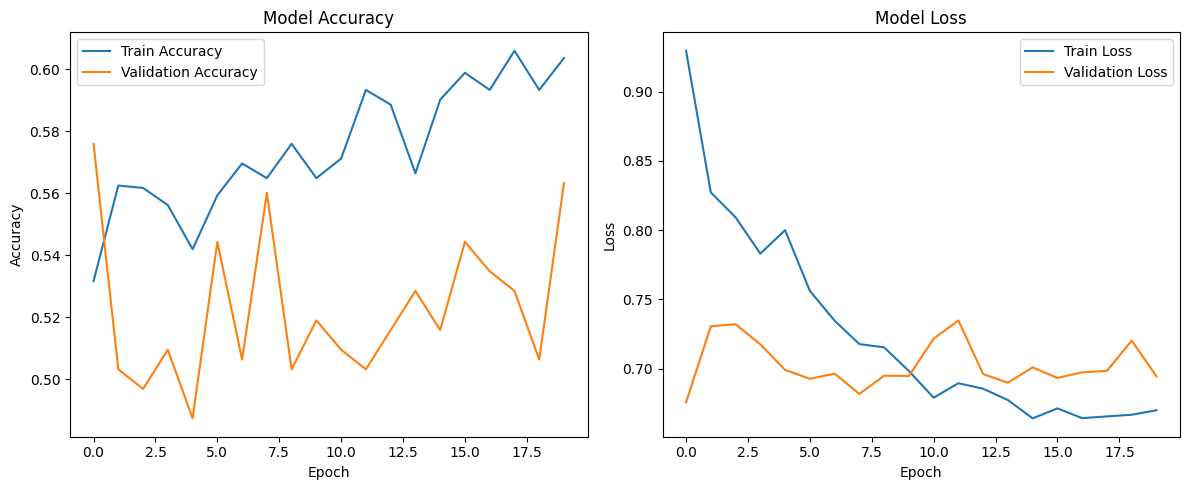


ROC AUC: 0.6264


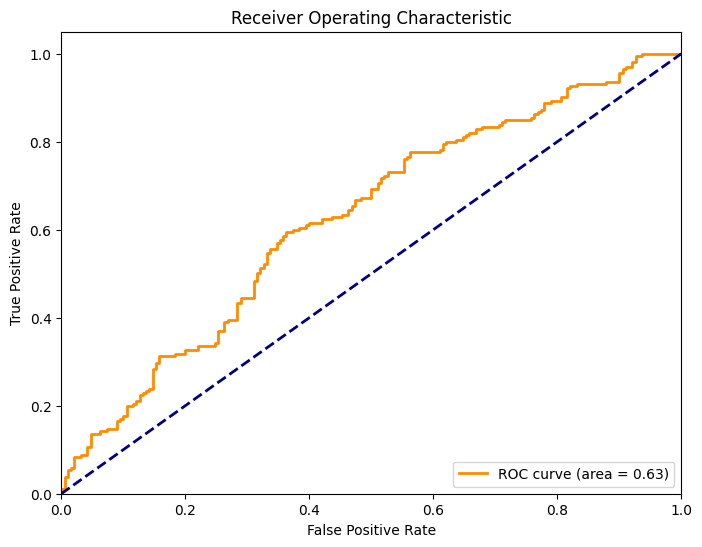

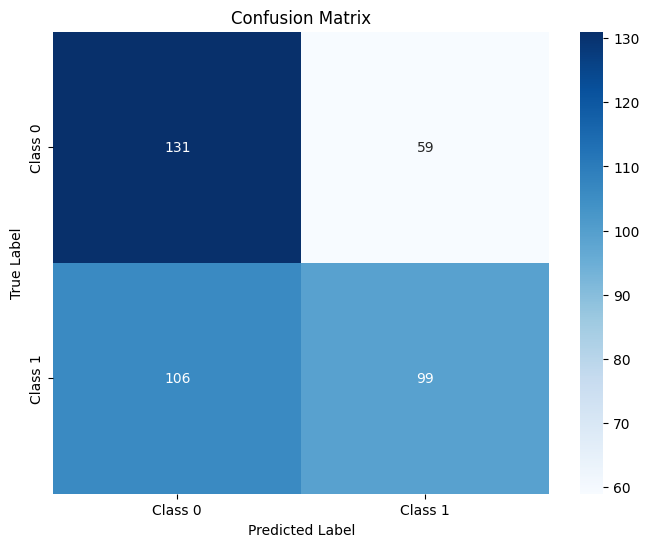

In [2]:
# Load feature and target data
features = pd.read_csv(r"D:\JN\data set\created dataset\ECG_PCG_LR_20Features.csv", header=None, skiprows=[0])  # Adjust header based on your CSV format
targets = pd.read_csv(r'D:\JN\data set\data from web\Reference_aug.csv', header=None)

print(features.shape)
print(targets.shape)

# Extract target column
y = targets.iloc[:, -1]  # Selecting the last column
X = features  # All feature columns

# Using .apply() method
y = y.apply(lambda x: max(x, 0))

# Split data into training and testing sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

# Reshape data for Conv1D input
Xtrain_reshaped = Xtrain_scaled.reshape((Xtrain_scaled.shape[0], Xtrain_scaled.shape[1], 1))
Xtest_reshaped = Xtest_scaled.reshape((Xtest_scaled.shape[0], Xtest_scaled.shape[1], 1))
#----------------------------------------------------------------------------------------
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Concatenate, Flatten, Dense

input_layer = Input(shape=(20, 1))

# --- First Multi-Scale Block ---
conv3a = Conv1D(8, kernel_size=3, padding='same', activation='relu')(input_layer)
conv5a = Conv1D(16, kernel_size=5, padding='same', activation='relu')(input_layer)
conv7a = Conv1D(32, kernel_size=7, padding='same', activation='relu')(input_layer)

merged1 = Concatenate(axis=-1)([conv3a, conv5a, conv7a])
merged1 = BatchNormalization()(merged1)
merged1 = Dropout(0.5)(merged1)

# --- Second Multi-Scale Block ---
conv3b = Conv1D(16, kernel_size=3, padding='same', activation='relu')(merged1)
conv5b = Conv1D(32, kernel_size=5, padding='same', activation='relu')(merged1)
conv7b = Conv1D(8, kernel_size=7, padding='same', activation='relu')(merged1)

merged2 = Concatenate(axis=-1)([conv3b, conv5b, conv7b])
merged2 = BatchNormalization()(merged2)
merged2 = Dropout(0.5)(merged2)

# --- Final (Third) Multi-Scale Block ---
conv3c = Conv1D(32, kernel_size=3, padding='same', activation='relu')(merged2)
conv5c = Conv1D(8, kernel_size=5, padding='same', activation='relu')(merged2)
conv7c = Conv1D(16, kernel_size=7, padding='same', activation='relu')(merged2)

merged3 = Concatenate(axis=-1)([conv3c, conv5c, conv7c])
merged3 = BatchNormalization()(merged3)
merged3 = Dropout(0.5)(merged3)

# --- Fully Connected Layers ---
flattened = Flatten()(merged3)
dense = Dense(128, activation='relu')(flattened)
#dense = Dense(128, activation='relu')(dense)
#dense = Dense(128, activation='relu')(dense)
#dense = Dense(128, activation='relu')(dense)

# Output Layer for Binary Classification
output = Dense(1, activation='sigmoid')(dense)

# Compile Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(Xtrain_reshaped, Ytrain, epochs=20, batch_size=32, validation_split=0.2)
#---------------------------------------------------------------------------------------------
# Evaluate the model on the test set
loss, accuracy = model.evaluate(Xtest_reshaped, Ytest)
print(f"Test Accuracy: {accuracy:.2%}")
print(f"Test Loss: {loss:.4f}")
#--------------------------------------------------------------------------
Ypred = model.predict(Xtest_reshaped)
Ypred_classes = (Ypred > 0.5).astype(int)
Ypred_classes_flat = Ypred_classes.flatten()

# Print classification report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(Ytest, Ypred_classes_flat)) # Use Ytest directly
#-------------------------------------------------------------------------
# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
#------------------------------------------------------------------------
roc_auc = roc_auc_score(Ytest, Ypred[:, 0])
print(f"\nROC AUC: {roc_auc:.4f}")

# Plot ROC curve
# Use Ytest for true labels and Ypred[:, 0] for predicted probabilities of the positive class
fpr, tpr, thresholds = roc_curve(Ytest, Ypred[:, 0])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
#------------------------------------------------------------------------
cm = confusion_matrix(Ytest, Ypred_classes_flat)
plt.figure(figsize=(8, 6))
class_labels = ['Class 0', 'Class 1'] # Or provide your actual class names if available

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 50 features

(1975, 50)
(1975, 2)
Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.5633 - loss: 0.9082 - val_accuracy: 0.5253 - val_loss: 0.6957
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5708 - loss: 0.9240 - val_accuracy: 0.4873 - val_loss: 0.7465
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6132 - loss: 0.8344 - val_accuracy: 0.4842 - val_loss: 0.7795
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5814 - loss: 0.8168 - val_accuracy: 0.4747 - val_loss: 0.9022
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6222 - loss: 0.7695 - val_accuracy: 0.4968 - val_loss: 1.0234
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6085 - loss: 0.7278 - val_accuracy: 0.4937 - val_loss: 0.9524
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6011 - loss: 0.7013 - val_accuracy: 0.5063 - val_loss: 0.7698
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6392 - loss: 0.6500 - val

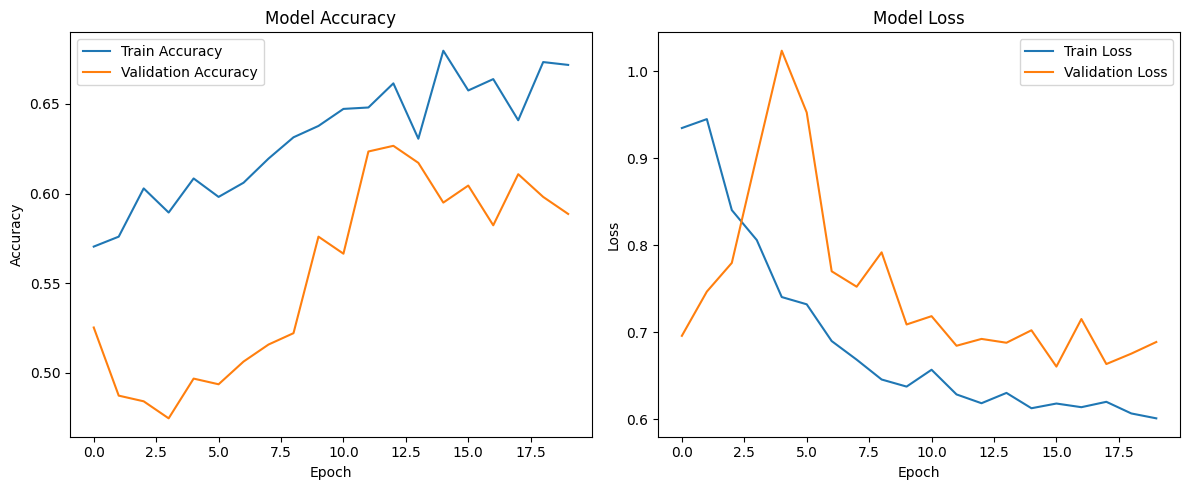


ROC AUC: 0.6504


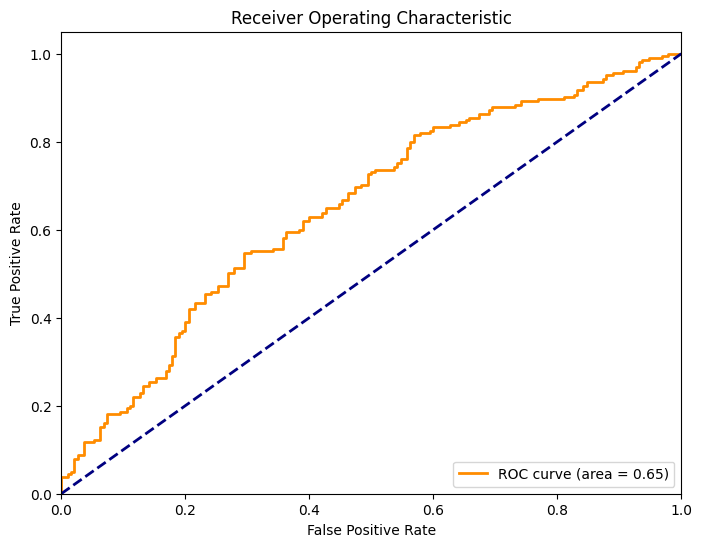

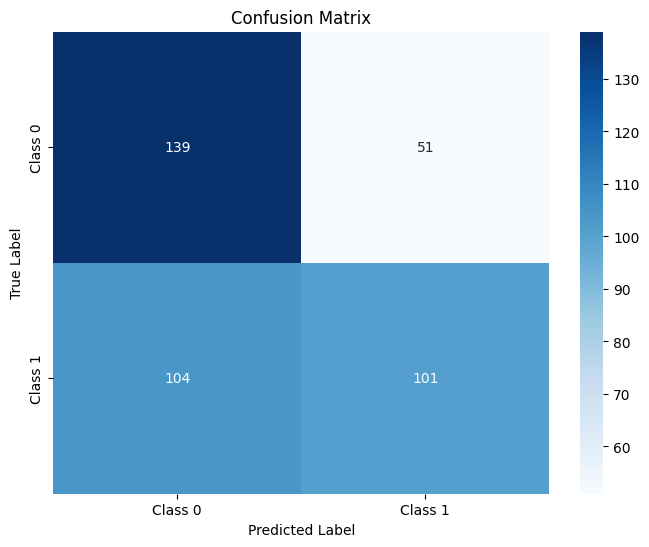

In [3]:
# Load feature and target data
features = pd.read_csv(r"D:\JN\data set\created dataset\ECG_PCG_LR_50Features.csv", header=None, skiprows=[0])  # Adjust header based on your CSV format
targets = pd.read_csv(r'D:\JN\data set\data from web\Reference_aug.csv', header=None)

print(features.shape)
print(targets.shape)

# Extract target column
y = targets.iloc[:, -1]  # Selecting the last column
X = features  # All feature columns

# Using .apply() method
y = y.apply(lambda x: max(x, 0))

# Split data into training and testing sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

# Reshape data for Conv1D input
Xtrain_reshaped = Xtrain_scaled.reshape((Xtrain_scaled.shape[0], Xtrain_scaled.shape[1], 1))
Xtest_reshaped = Xtest_scaled.reshape((Xtest_scaled.shape[0], Xtest_scaled.shape[1], 1))
#----------------------------------------------------------------------------------------
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Concatenate, Flatten, Dense

input_layer = Input(shape=(50, 1))

# --- First Multi-Scale Block ---
conv3a = Conv1D(8, kernel_size=3, padding='same', activation='relu')(input_layer)
conv5a = Conv1D(16, kernel_size=5, padding='same', activation='relu')(input_layer)
conv7a = Conv1D(32, kernel_size=7, padding='same', activation='relu')(input_layer)

merged1 = Concatenate(axis=-1)([conv3a, conv5a, conv7a])
merged1 = BatchNormalization()(merged1)
merged1 = Dropout(0.5)(merged1)

# --- Second Multi-Scale Block ---
conv3b = Conv1D(16, kernel_size=3, padding='same', activation='relu')(merged1)
conv5b = Conv1D(32, kernel_size=5, padding='same', activation='relu')(merged1)
conv7b = Conv1D(8, kernel_size=7, padding='same', activation='relu')(merged1)

merged2 = Concatenate(axis=-1)([conv3b, conv5b, conv7b])
merged2 = BatchNormalization()(merged2)
merged2 = Dropout(0.5)(merged2)

# --- Final (Third) Multi-Scale Block ---
conv3c = Conv1D(32, kernel_size=3, padding='same', activation='relu')(merged2)
conv5c = Conv1D(8, kernel_size=5, padding='same', activation='relu')(merged2)
conv7c = Conv1D(16, kernel_size=7, padding='same', activation='relu')(merged2)

merged3 = Concatenate(axis=-1)([conv3c, conv5c, conv7c])
merged3 = BatchNormalization()(merged3)
merged3 = Dropout(0.5)(merged3)

# --- Fully Connected Layers ---
flattened = Flatten()(merged3)
dense = Dense(128, activation='relu')(flattened)
#dense = Dense(128, activation='relu')(dense)
#dense = Dense(128, activation='relu')(dense)
#dense = Dense(128, activation='relu')(dense)

# Output Layer for Binary Classification
output = Dense(1, activation='sigmoid')(dense)

# Compile Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(Xtrain_reshaped, Ytrain, epochs=20, batch_size=32, validation_split=0.2)
#---------------------------------------------------------------------------------------------
# Evaluate the model on the test set
loss, accuracy = model.evaluate(Xtest_reshaped, Ytest)
print(f"Test Accuracy: {accuracy:.2%}")
print(f"Test Loss: {loss:.4f}")
#--------------------------------------------------------------------------
Ypred = model.predict(Xtest_reshaped)
Ypred_classes = (Ypred > 0.5).astype(int)
Ypred_classes_flat = Ypred_classes.flatten()

# Print classification report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(Ytest, Ypred_classes_flat)) # Use Ytest directly
#-------------------------------------------------------------------------
# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
#------------------------------------------------------------------------
roc_auc = roc_auc_score(Ytest, Ypred[:, 0])
print(f"\nROC AUC: {roc_auc:.4f}")

# Plot ROC curve
# Use Ytest for true labels and Ypred[:, 0] for predicted probabilities of the positive class
fpr, tpr, thresholds = roc_curve(Ytest, Ypred[:, 0])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
#------------------------------------------------------------------------
cm = confusion_matrix(Ytest, Ypred_classes_flat)
plt.figure(figsize=(8, 6))
class_labels = ['Class 0', 'Class 1'] # Or provide your actual class names if available

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 100 Features

(1975, 100)
(1975, 2)
Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.5559 - loss: 1.1712 - val_accuracy: 0.5285 - val_loss: 0.7009
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.5677 - loss: 1.1699 - val_accuracy: 0.5190 - val_loss: 0.6890
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.6325 - loss: 0.7573 - val_accuracy: 0.4842 - val_loss: 0.6978
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6154 - loss: 0.6707 - val_accuracy: 0.6361 - val_loss: 0.6779
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.6869 - loss: 0.6269 - val_accuracy: 0.5443 - val_loss: 0.6849
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6680 - loss: 0.6247 - val_accuracy: 0.5285 - val_loss: 0.6896
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.7113 - loss: 0.5808 - val_accuracy: 0.6139 - val_loss: 0.6505
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.6811 - loss: 0.5980 - v

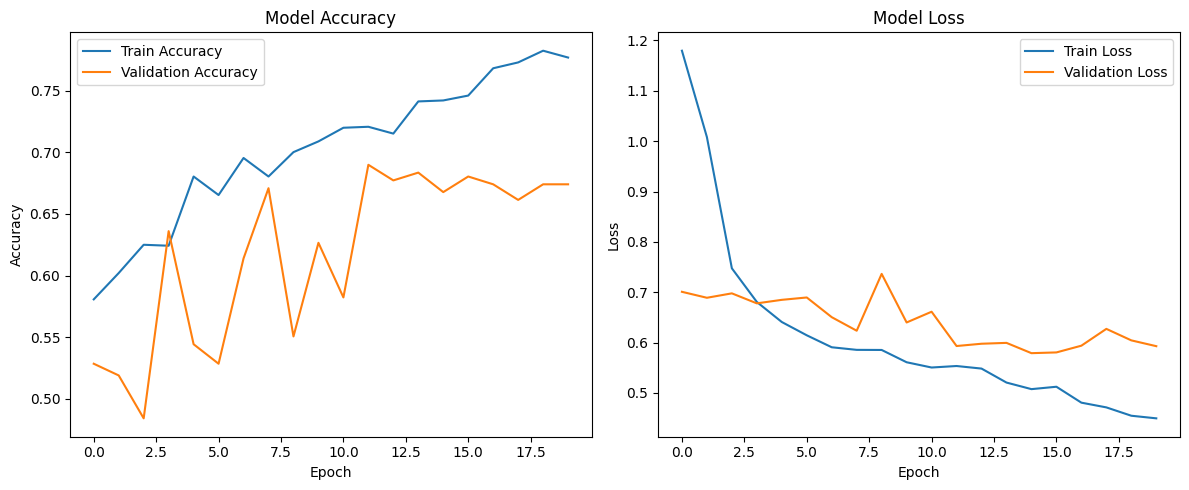


ROC AUC: 0.7178


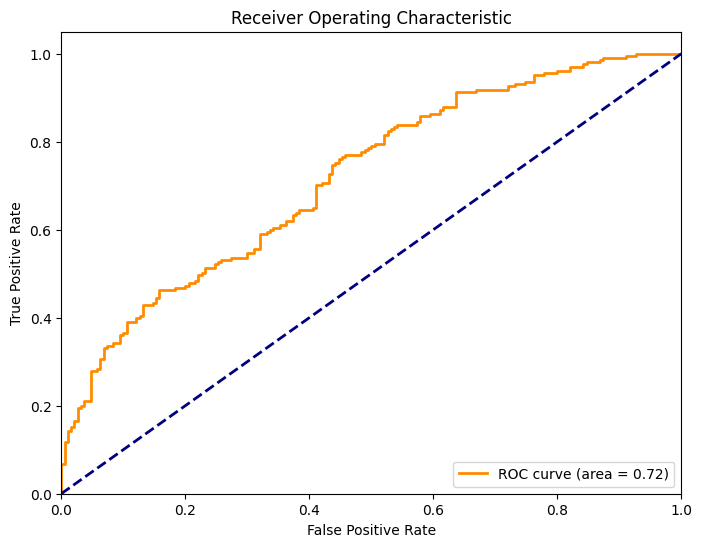

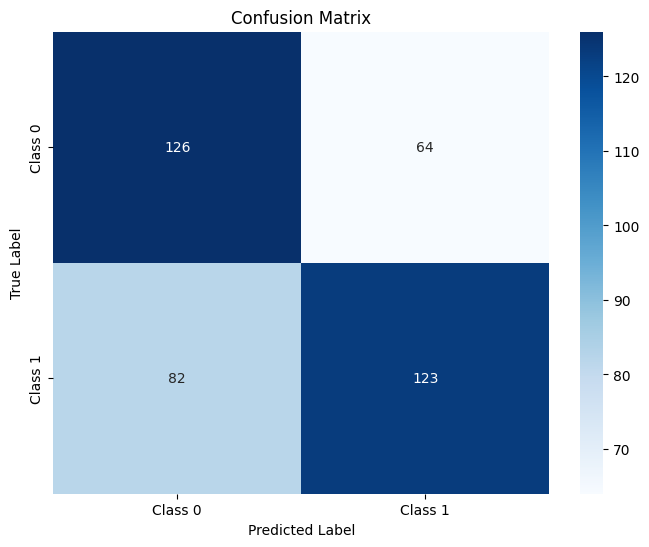

In [4]:
# Load feature and target data
features = pd.read_csv(r"D:\JN\data set\created dataset\ECG_PCG_LR_100Features.csv", header=None, skiprows=[0])  # Adjust header based on your CSV format
targets = pd.read_csv(r'D:\JN\data set\data from web\Reference_aug.csv', header=None)

print(features.shape)
print(targets.shape)

# Extract target column
y = targets.iloc[:, -1]  # Selecting the last column
X = features  # All feature columns

# Using .apply() method
y = y.apply(lambda x: max(x, 0))

# Split data into training and testing sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

# Reshape data for Conv1D input
Xtrain_reshaped = Xtrain_scaled.reshape((Xtrain_scaled.shape[0], Xtrain_scaled.shape[1], 1))
Xtest_reshaped = Xtest_scaled.reshape((Xtest_scaled.shape[0], Xtest_scaled.shape[1], 1))
#----------------------------------------------------------------------------------------
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Concatenate, Flatten, Dense

input_layer = Input(shape=(100, 1))

# --- First Multi-Scale Block ---
conv3a = Conv1D(8, kernel_size=3, padding='same', activation='relu')(input_layer)
conv5a = Conv1D(16, kernel_size=5, padding='same', activation='relu')(input_layer)
conv7a = Conv1D(32, kernel_size=7, padding='same', activation='relu')(input_layer)

merged1 = Concatenate(axis=-1)([conv3a, conv5a, conv7a])
merged1 = BatchNormalization()(merged1)
merged1 = Dropout(0.5)(merged1)

# --- Second Multi-Scale Block ---
conv3b = Conv1D(16, kernel_size=3, padding='same', activation='relu')(merged1)
conv5b = Conv1D(32, kernel_size=5, padding='same', activation='relu')(merged1)
conv7b = Conv1D(8, kernel_size=7, padding='same', activation='relu')(merged1)

merged2 = Concatenate(axis=-1)([conv3b, conv5b, conv7b])
merged2 = BatchNormalization()(merged2)
merged2 = Dropout(0.5)(merged2)

# --- Final (Third) Multi-Scale Block ---
conv3c = Conv1D(32, kernel_size=3, padding='same', activation='relu')(merged2)
conv5c = Conv1D(8, kernel_size=5, padding='same', activation='relu')(merged2)
conv7c = Conv1D(16, kernel_size=7, padding='same', activation='relu')(merged2)

merged3 = Concatenate(axis=-1)([conv3c, conv5c, conv7c])
merged3 = BatchNormalization()(merged3)
merged3 = Dropout(0.5)(merged3)

# --- Fully Connected Layers ---
flattened = Flatten()(merged3)
dense = Dense(128, activation='relu')(flattened)
#dense = Dense(128, activation='relu')(dense)
#dense = Dense(128, activation='relu')(dense)
#dense = Dense(128, activation='relu')(dense)

# Output Layer for Binary Classification
output = Dense(1, activation='sigmoid')(dense)

# Compile Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(Xtrain_reshaped, Ytrain, epochs=20, batch_size=32, validation_split=0.2)
#---------------------------------------------------------------------------------------------
# Evaluate the model on the test set
loss, accuracy = model.evaluate(Xtest_reshaped, Ytest)
print(f"Test Accuracy: {accuracy:.2%}")
print(f"Test Loss: {loss:.4f}")
#--------------------------------------------------------------------------
Ypred = model.predict(Xtest_reshaped)
Ypred_classes = (Ypred > 0.5).astype(int)
Ypred_classes_flat = Ypred_classes.flatten()

# Print classification report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(Ytest, Ypred_classes_flat)) # Use Ytest directly
#-------------------------------------------------------------------------
# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
#------------------------------------------------------------------------
roc_auc = roc_auc_score(Ytest, Ypred[:, 0])
print(f"\nROC AUC: {roc_auc:.4f}")

# Plot ROC curve
# Use Ytest for true labels and Ypred[:, 0] for predicted probabilities of the positive class
fpr, tpr, thresholds = roc_curve(Ytest, Ypred[:, 0])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
#------------------------------------------------------------------------
cm = confusion_matrix(Ytest, Ypred_classes_flat)
plt.figure(figsize=(8, 6))
class_labels = ['Class 0', 'Class 1'] # Or provide your actual class names if available

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 150 Features

(1975, 150)
(1975, 2)
Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.5610 - loss: 1.0195 - val_accuracy: 0.5696 - val_loss: 0.6827
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.6086 - loss: 1.0176 - val_accuracy: 0.6076 - val_loss: 0.6768
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.6415 - loss: 0.7416 - val_accuracy: 0.5443 - val_loss: 0.6742
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.6680 - loss: 0.6365 - val_accuracy: 0.6551 - val_loss: 0.6530
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7177 - loss: 0.5712 - val_accuracy: 0.5253 - val_loss: 0.7273
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7155 - loss: 0.5739 - val_accuracy: 0.6392 - val_loss: 0.6374
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7458 - loss: 0.5389 - val_accuracy: 0.6519 - val_loss: 0.6294
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.7755 - loss: 0.4936 - v

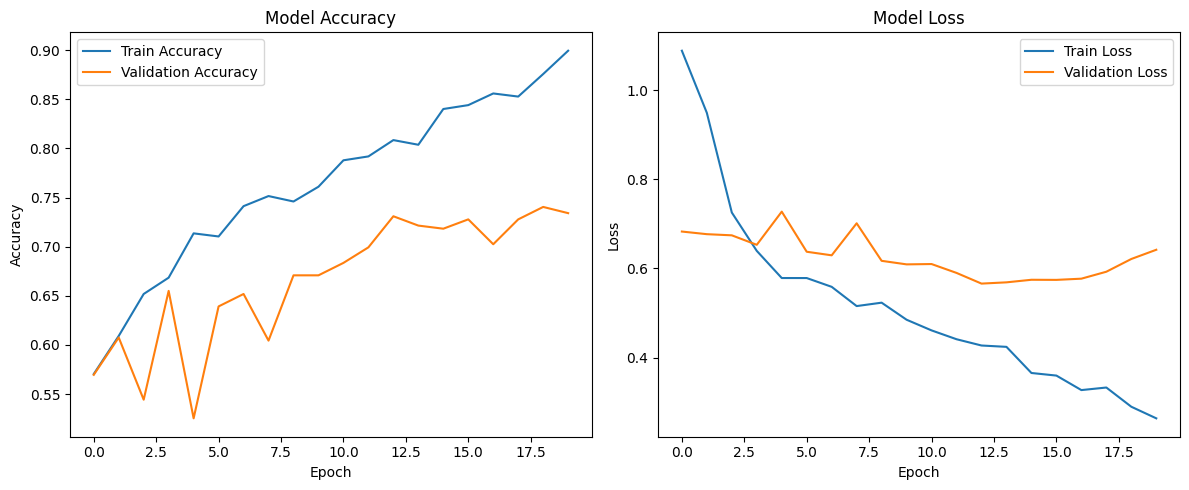


ROC AUC: 0.7974


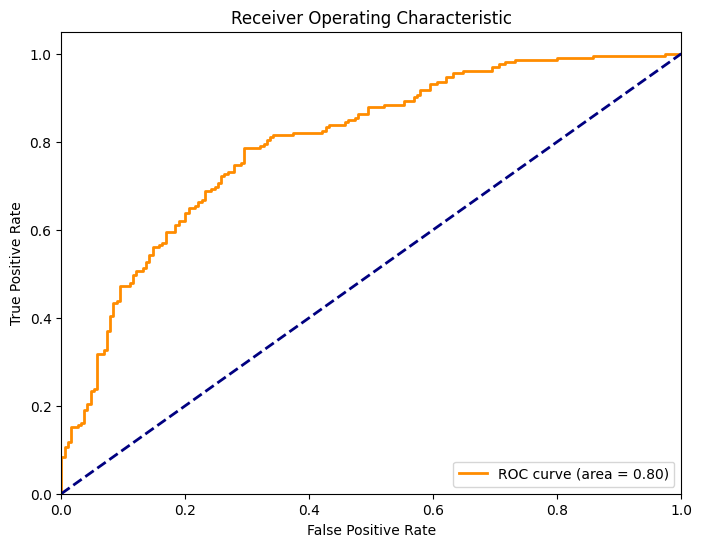

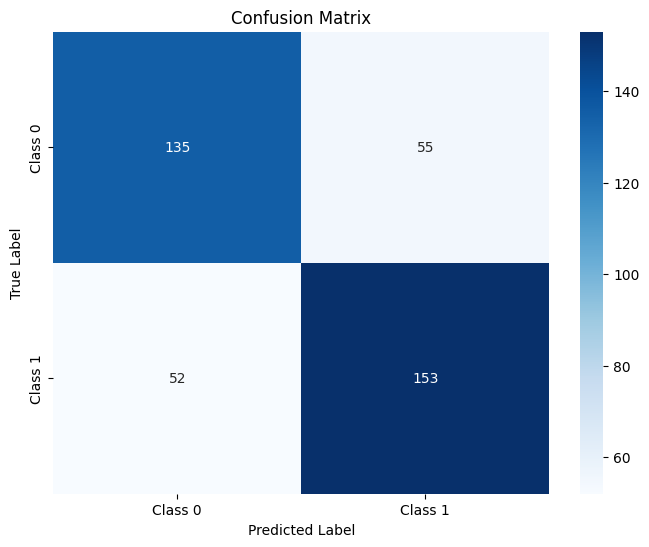

In [5]:
# Load feature and target data
features = pd.read_csv(r"D:\JN\data set\created dataset\ECG_PCG_LR_150Features.csv", header=None, skiprows=[0])  # Adjust header based on your CSV format
targets = pd.read_csv(r'D:\JN\data set\data from web\Reference_aug.csv', header=None)

print(features.shape)
print(targets.shape)

# Extract target column
y = targets.iloc[:, -1]  # Selecting the last column
X = features  # All feature columns

# Using .apply() method
y = y.apply(lambda x: max(x, 0))

# Split data into training and testing sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

# Reshape data for Conv1D input
Xtrain_reshaped = Xtrain_scaled.reshape((Xtrain_scaled.shape[0], Xtrain_scaled.shape[1], 1))
Xtest_reshaped = Xtest_scaled.reshape((Xtest_scaled.shape[0], Xtest_scaled.shape[1], 1))
#----------------------------------------------------------------------------------------
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Concatenate, Flatten, Dense

input_layer = Input(shape=(150, 1))

# --- First Multi-Scale Block ---
conv3a = Conv1D(8, kernel_size=3, padding='same', activation='relu')(input_layer)
conv5a = Conv1D(16, kernel_size=5, padding='same', activation='relu')(input_layer)
conv7a = Conv1D(32, kernel_size=7, padding='same', activation='relu')(input_layer)

merged1 = Concatenate(axis=-1)([conv3a, conv5a, conv7a])
merged1 = BatchNormalization()(merged1)
merged1 = Dropout(0.5)(merged1)

# --- Second Multi-Scale Block ---
conv3b = Conv1D(16, kernel_size=3, padding='same', activation='relu')(merged1)
conv5b = Conv1D(32, kernel_size=5, padding='same', activation='relu')(merged1)
conv7b = Conv1D(8, kernel_size=7, padding='same', activation='relu')(merged1)

merged2 = Concatenate(axis=-1)([conv3b, conv5b, conv7b])
merged2 = BatchNormalization()(merged2)
merged2 = Dropout(0.5)(merged2)

# --- Final (Third) Multi-Scale Block ---
conv3c = Conv1D(32, kernel_size=3, padding='same', activation='relu')(merged2)
conv5c = Conv1D(8, kernel_size=5, padding='same', activation='relu')(merged2)
conv7c = Conv1D(16, kernel_size=7, padding='same', activation='relu')(merged2)

merged3 = Concatenate(axis=-1)([conv3c, conv5c, conv7c])
merged3 = BatchNormalization()(merged3)
merged3 = Dropout(0.5)(merged3)

# --- Fully Connected Layers ---
flattened = Flatten()(merged3)
dense = Dense(128, activation='relu')(flattened)
#dense = Dense(128, activation='relu')(dense)
#dense = Dense(128, activation='relu')(dense)
#dense = Dense(128, activation='relu')(dense)

# Output Layer for Binary Classification
output = Dense(1, activation='sigmoid')(dense)

# Compile Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(Xtrain_reshaped, Ytrain, epochs=20, batch_size=32, validation_split=0.2)
#---------------------------------------------------------------------------------------------
# Evaluate the model on the test set
loss, accuracy = model.evaluate(Xtest_reshaped, Ytest)
print(f"Test Accuracy: {accuracy:.2%}")
print(f"Test Loss: {loss:.4f}")
#--------------------------------------------------------------------------
Ypred = model.predict(Xtest_reshaped)
Ypred_classes = (Ypred > 0.5).astype(int)
Ypred_classes_flat = Ypred_classes.flatten()

# Print classification report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(Ytest, Ypred_classes_flat)) # Use Ytest directly
#-------------------------------------------------------------------------
# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
#------------------------------------------------------------------------
roc_auc = roc_auc_score(Ytest, Ypred[:, 0])
print(f"\nROC AUC: {roc_auc:.4f}")

# Plot ROC curve
# Use Ytest for true labels and Ypred[:, 0] for predicted probabilities of the positive class
fpr, tpr, thresholds = roc_curve(Ytest, Ypred[:, 0])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
#------------------------------------------------------------------------
cm = confusion_matrix(Ytest, Ypred_classes_flat)
plt.figure(figsize=(8, 6))
class_labels = ['Class 0', 'Class 1'] # Or provide your actual class names if available

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 200 Features

(1975, 200)
(1975, 2)
Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - accuracy: 0.5757 - loss: 1.1340 - val_accuracy: 0.6361 - val_loss: 0.6635
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.6609 - loss: 1.0392 - val_accuracy: 0.5601 - val_loss: 0.6826
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.6876 - loss: 0.6597 - val_accuracy: 0.6582 - val_loss: 0.6205
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.7111 - loss: 0.5974 - val_accuracy: 0.5949 - val_loss: 0.7079
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.7526 - loss: 0.5194 - val_accuracy: 0.6551 - val_loss: 0.6047
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.7476 - loss: 0.5250 - val_accuracy: 0.6614 - val_loss: 0.6515
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.7550 - loss: 0.4811 - val_accuracy: 0.6361 - val_loss: 0.8296
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.8125 - loss: 0.4031 - 

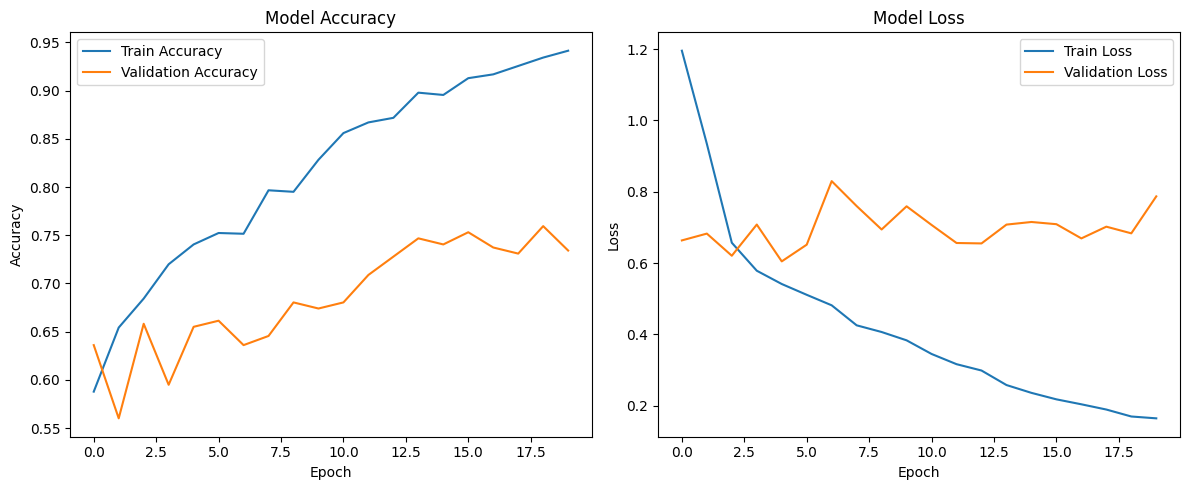


ROC AUC: 0.8392


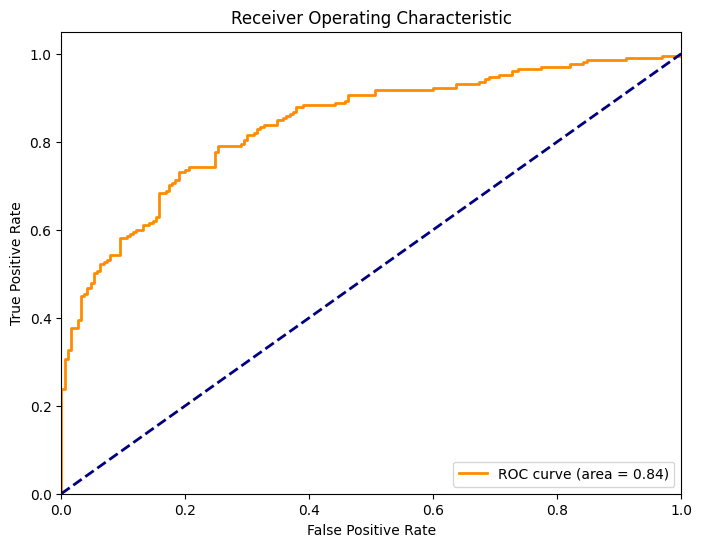

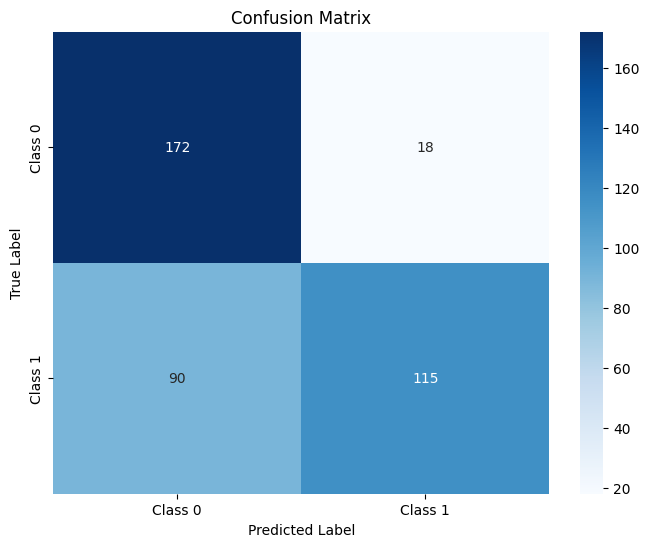

In [6]:
# Load feature and target data
features = pd.read_csv(r"D:\JN\data set\created dataset\ECG_PCG_LR_200Features.csv", header=None, skiprows=[0])  # Adjust header based on your CSV format
targets = pd.read_csv(r'D:\JN\data set\data from web\Reference_aug.csv', header=None)

print(features.shape)
print(targets.shape)

# Extract target column
y = targets.iloc[:, -1]  # Selecting the last column
X = features  # All feature columns

# Using .apply() method
y = y.apply(lambda x: max(x, 0))

# Split data into training and testing sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

# Reshape data for Conv1D input
Xtrain_reshaped = Xtrain_scaled.reshape((Xtrain_scaled.shape[0], Xtrain_scaled.shape[1], 1))
Xtest_reshaped = Xtest_scaled.reshape((Xtest_scaled.shape[0], Xtest_scaled.shape[1], 1))
#----------------------------------------------------------------------------------------
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Concatenate, Flatten, Dense

input_layer = Input(shape=(200, 1))

# --- First Multi-Scale Block ---
conv3a = Conv1D(8, kernel_size=3, padding='same', activation='relu')(input_layer)
conv5a = Conv1D(16, kernel_size=5, padding='same', activation='relu')(input_layer)
conv7a = Conv1D(32, kernel_size=7, padding='same', activation='relu')(input_layer)

merged1 = Concatenate(axis=-1)([conv3a, conv5a, conv7a])
merged1 = BatchNormalization()(merged1)
merged1 = Dropout(0.5)(merged1)

# --- Second Multi-Scale Block ---
conv3b = Conv1D(16, kernel_size=3, padding='same', activation='relu')(merged1)
conv5b = Conv1D(32, kernel_size=5, padding='same', activation='relu')(merged1)
conv7b = Conv1D(8, kernel_size=7, padding='same', activation='relu')(merged1)

merged2 = Concatenate(axis=-1)([conv3b, conv5b, conv7b])
merged2 = BatchNormalization()(merged2)
merged2 = Dropout(0.5)(merged2)

# --- Final (Third) Multi-Scale Block ---
conv3c = Conv1D(32, kernel_size=3, padding='same', activation='relu')(merged2)
conv5c = Conv1D(8, kernel_size=5, padding='same', activation='relu')(merged2)
conv7c = Conv1D(16, kernel_size=7, padding='same', activation='relu')(merged2)

merged3 = Concatenate(axis=-1)([conv3c, conv5c, conv7c])
merged3 = BatchNormalization()(merged3)
merged3 = Dropout(0.5)(merged3)

# --- Fully Connected Layers ---
flattened = Flatten()(merged3)
dense = Dense(128, activation='relu')(flattened)
#dense = Dense(128, activation='relu')(dense)
#dense = Dense(128, activation='relu')(dense)
#dense = Dense(128, activation='relu')(dense)

# Output Layer for Binary Classification
output = Dense(1, activation='sigmoid')(dense)

# Compile Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(Xtrain_reshaped, Ytrain, epochs=20, batch_size=32, validation_split=0.2)
#---------------------------------------------------------------------------------------------
# Evaluate the model on the test set
loss, accuracy = model.evaluate(Xtest_reshaped, Ytest)
print(f"Test Accuracy: {accuracy:.2%}")
print(f"Test Loss: {loss:.4f}")
#--------------------------------------------------------------------------
Ypred = model.predict(Xtest_reshaped)
Ypred_classes = (Ypred > 0.5).astype(int)
Ypred_classes_flat = Ypred_classes.flatten()

# Print classification report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(Ytest, Ypred_classes_flat)) # Use Ytest directly
#-------------------------------------------------------------------------
# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
#------------------------------------------------------------------------
roc_auc = roc_auc_score(Ytest, Ypred[:, 0])
print(f"\nROC AUC: {roc_auc:.4f}")

# Plot ROC curve
# Use Ytest for true labels and Ypred[:, 0] for predicted probabilities of the positive class
fpr, tpr, thresholds = roc_curve(Ytest, Ypred[:, 0])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
#------------------------------------------------------------------------
cm = confusion_matrix(Ytest, Ypred_classes_flat)
plt.figure(figsize=(8, 6))
class_labels = ['Class 0', 'Class 1'] # Or provide your actual class names if available

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()